I aim at searching a model which help predict if a message reflects depression hints.

Ref: https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned/data?select=depression_dataset_reddit_cleaned.csv

In [2]:
pip install num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 7.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7367aae899caec949eb51fa67c182cf5e6fedb1f9be95ff65825174c86518d84
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt


In [3]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=6f46c6addbc02399cbb5474b51e6929173f38e8a1eedff93a87e80bd20bc5c81
  Stored in directory: /root/.cache/pip/wheels/b6/28/c2/9ddf8f57f871b55b6fd0ab99c887531fb9a66e5ff236b82aee
Successfully built autocorrect


In [4]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [5]:
from num2words import num2words
import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

# ML imports:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# DL imports:
from transformers import AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import evaluate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
# Items:
# do_preprocessing: Logical, should preprocessing be performed
# do_enhanced_preprocessing: Logical, should the computation-heavy preprocessing be performed
# do_feature_eng: Logical
# maximize_a_priori: Logocal, should the univariate preliminary feature selection be based on a priori or a postiori stats
# num_chosen_features_per_class: Int, for the preliminary feature selection, how many features should be selected per class
# test_size: ratio between 0 - 1
# feature_eng_details: Either "TfidfVectorizer" (for TFIDF feature eng.) or "CountVectorizer" (for one hot encoding)
# seed: Integer, the random seed used to insure reproducibility of results

config_dict = {'do_preprocessing': True,
               'do_enhanced_preprocessing': False,
               'do_feature_eng': True,
               'maximize_a_priori': False,
               'num_chosen_features_per_class': 200,
               'test_size': 0.25,
               'feature_eng_details': "CountVectorizer-binary",
               'ngram_range_min': 1,
               'ngram_range_max': 3,
               'max_features': 1000,
               'seed': 0}

# Deep learning training parameters:
# See description of input parameters in documentation for transformers.TrainingArguments.
lm_training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=4, #2
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    eval_strategy="steps",
    logging_steps=100,
    report_to=[],  # Disable logging to Weights & Biases or other services
    )

layers_to_fine_tune = None

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [7]:
# Mount my Google drive so you can read them easily
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("infamouscoder/depression-reddit-cleaned")

print("Path to dataset files:", path)

100%|██████████| 979k/979k [00:00<00:00, 29.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/infamouscoder/depression-reddit-cleaned/versions/1


In [9]:
import os
import pandas as pd

# Construct the full path to the CSV file
csv_file_path = os.path.join(path, "depression_dataset_reddit_cleaned.csv")

# Read the CSV file into a pandas DataFrame
try:
    df = pd.read_csv(csv_file_path)
    print("Successfully loaded 'depression_dataset_reddit_cleaned.csv':")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")

Successfully loaded 'depression_dataset_reddit_cleaned.csv':
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [10]:
df.head()

clean_text  \
0  we understand that most people who reply immediately to an op with an invitation to talk privately mean only to help but this type of response usually lead to either disappointment or disaster it usually work out quite differently here than when you say pm me anytime in a casual social context we have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content even more so because we know that so many of you are struggling yourselves we re hard at work behind the scene on more information and resource to make it easier to give and get quality help here this is just a small start our new wiki page explains in detail why it s much better to respond in public comment at least until you ve gotten to know someone it will be maintained at r depression wiki private contact and the full text of the current version is below summary anyone who while acting a a helper invite or accepts private contact i e pm chat or any kind of offsite communication early in the conversion is showing either bad intention or bad judgement either way it s unwise to trust them pm me anytime seems like a kind and generous offer and it might be perfectly well meaning but unless and until a solid rapport ha been established it s just not a wise idea here are some point to consider before you offer or accept an invitation to communicate privately by posting supportive reply publicly you ll help more people than just the op if your response are of good quality you ll educate and inspire other helper the 9 90 rule http en wikipedia org wiki rule internet culture applies here a much a it doe anywhere else on the internet people who are struggling with serious mental health issue often justifiably have a low tolerance for disappointment and a high level of ever changing emotional need unless the helper is able to make a 00 commitment to be there for them in every way for a long a necessary offering a personal inbox a a resource is likely to do more harm than good this is why mental health crisis line responder usually don t give their name and caller aren t allowed to request specific responder it s much healthier and safer for the caller to develop a relationship with the agency a a whole analogously it s much safer and healthier for our ops to develop a relationship with the community a a whole even trained responder are generally not allowed to work high intensity situation alone it s partly about availability but it s mostly about wider perspective and preventing compassion fatigue if a helper get in over their head with someone whose mental health issue including suicidality which is often comorbid with depression escalate in a pm conversation it s much harder for others including the r depression and r suicidewatch moderator to help contrary to common assumption moderator can t see or police pm in our observation over many year the people who say pm me the most are consistently the one with the least understanding of mental health issue and mental health support we all have gap in our knowledge and in our ability to communicate effectively community input mitigates these limitation there s no reason why someone who s truly here to help would want to hide their response from community scrutiny if helper are concerned about their own privacy keep in mind that self disclosure when used supportively is more about the feeling than the detail and that we have no problem here with the use of alt throwaway account and have no restriction on account age or karma we all know the internet is used by some people to exploit or abuse others these people do want to hide their deceptive and manipulative response from everyone except their victim there are many of them who specifically target those who are vulnerable because of mental health issue if a helper invite an op to talk privately and give them a good supportive experience they ve primed that person to be more vulnera

In [11]:
df.tail()

,clean_text,is_depression
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear this creepy nick pirro version,0
7730,slept wonderfully finally tried swatching for new project classic line cardi from stash but don t like color must wait for now,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [13]:
df[df.duplicated().values==True].shape

(81, 2)

In [14]:
df_prep = df.drop_duplicates().copy()
df_prep.shape

(7650, 2)

In [15]:
mask_NaN = df_prep.isnull().any(axis=1)
df_prep[mask_NaN].shape

(0, 2)

In [16]:
df_prep['is_depression'].value_counts()

,count
is_depression,
0,3889
1,3761


In [17]:
df_prep.index[0]

np.int64(0)

In [18]:
most_frequent_class = df_prep.index[0]
print("The most frequent class is:", most_frequent_class)
print("And its baseline accuracy is:", round((df_prep['is_depression'] == most_frequent_class).mean(), 3))

The most frequent class is: 0
And its baseline accuracy is: 0.508


Now let's look for a good model. Even though the data look quite clean, I will still do a bit further cleaning, to get rid of some words such as reflexive pronouns.

In [19]:
def spelling_correction(text):
    """
    Replace misspelled words with the correct spelling.

    Input: str
    Output: str
    """
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)


def remove_stop_words(text):
    """
    Remove stopwords.

    Input: str
    Output: str
    """
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])


def stemming(text):
    """
    Perform stemming of each word individually.

    Input: str
    Output: str
    """
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])


def lemmatizing(text):
    """
    Perform lemmatization for each word individually.

    Input: str
    Output: str
    """
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def preprocessing(input_text):
  """
  This function represents a complete pipeline for text preprocessing.

  Input: str
  Output: str
  """
  output = input_text
  # Lower casing:
  output = output.lower()
  # Remove punctuations and other special characters:
  output = re.sub('[^ A-Za-z0-9]+', '', output)

  if config_dict["do_enhanced_preprocessing"]:
    # Spelling corrections:
    output = spelling_correction(output)

  # Remove stop words:
  output = remove_stop_words(output)

  if config_dict["do_enhanced_preprocessing"]:
    # Stemming:
    output = stemming(output)
    # Lemmatizing:
    output = lemmatizing(output)

  return output

In [20]:
dataset_clean = df_prep.copy()
if config_dict["do_preprocessing"]:
  dataset_clean['clean_text'] = [preprocessing(text) for text in dataset_clean['clean_text']]

In [21]:
dataset_clean[['clean_text', 'is_depression']].head(10).style.set_properties(**{'text-align': 'left'})

,clean_text,is_depression
0,understand people reply immediately op invitation talk privately mean help type response usually lead either disappointment disaster usually work quite differently say pm anytime casual social context huge admiration appreciation goodwill good citizenship many support others flag inappropriate content even know many struggling hard work behind scene information resource make easier give get quality help small start new wiki page explains detail much better respond public comment least gotten know someone maintained r depression wiki private contact full text current version summary anyone acting helper invite accepts private contact e pm chat kind offsite communication early conversion showing either bad intention bad judgement either way unwise trust pm anytime seems like kind generous offer might perfectly well meaning unless solid rapport ha established wise idea point consider offer accept invitation communicate privately posting supportive reply publicly help people op response good quality educate inspire helper rule http en wikipedia org wiki rule internet culture applies much doe anywhere else internet people struggling serious mental health issue often justifiably low tolerance disappointment high level ever changing emotional need unless helper able make commitment every way long necessary offering personal inbox resource likely harm good mental health crisis line responder usually give name caller allowed request specific responder much healthier safer caller develop relationship agency whole analogously much safer healthier ops develop relationship community whole even trained responder generally allowed work high intensity situation alone partly availability mostly wider perspective preventing compassion fatigue helper get head someone whose mental health issue including suicidality often comorbid depression escalate pm conversation much harder others including r depression r suicidewatch moderator help contrary common assumption moderator see police pm observation many year people say pm consistently one least understanding mental health issue mental health support gap knowledge ability communicate effectively community input mitigates limitation reason someone truly help would want hide response community scrutiny helper concerned privacy keep mind self disclosure used supportively feeling detail problem use alt throwaway account restriction account age karma know internet used people exploit abuse others people want hide deceptive manipulative response everyone except victim many specifically target vulnerable mental health issue helper invite op talk privately give good supportive experience primed person vulnerable abuser sort cognitive priming tends particularly effective someone state mental health crisis people rely heuristic critical reasoning ops want talk privately posting wide open anonymous forum like reddit might best option although recommend allow ops request private contact asking support want please keep expectation realistic careful look history anyone offer pm opening,1
1,welcome r depression check post place take moment share going accomplishment want talk standalone post sub violate role model rule welcome tough time prefer make post place share subreddit rule located sidebar also always access r depression rule since exist important safety reason ask everyone read follow please click report harmful content see always want know deal soon also several wikis help finding giving support r depression wiki depression provides guidance depressive disorder guidance complex nature illness usually grouped depression label redirect information common topic issue r depression wiki giving help offer information nature value peer support mental health issue general lot guidance learning usually helpful giving peer support ysk type rule violation frequently see interfering people getting safe relevant support people breaking private contact rule never trust anyone try get privat

#EDA

In [22]:
import matplotlib.pyplot as plt

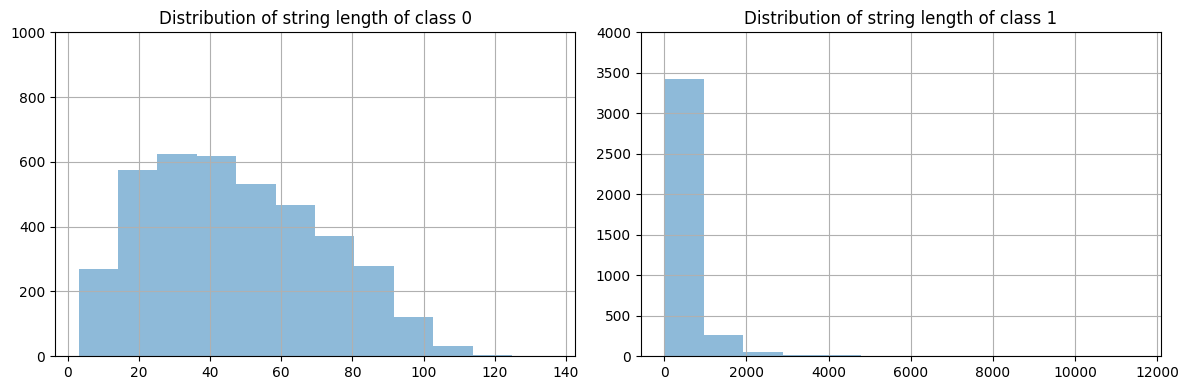

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=False, tight_layout=True)
bins = 12
axs[0].hist(dataset_clean[dataset_clean['is_depression']==0][["length of text"]], bins=bins, alpha=0.5)
axs[0].set_title("Distribution of string length of class 0")
axs[0].set_ylim(0,1000)
axs[0].grid(True)

axs[1].hist(dataset_clean[dataset_clean['is_depression']==1][["length of text"]], bins=bins, alpha=0.5)
axs[1].set_title("Distribution of string length of class 1")
axs[1].set_ylim(0,4000)
axs[1].grid(True)
plt.show()

It seems that the messages associated with depression are very lengthy!

Next, I try looking for the words that imply depression and non-depression.

#Feature Engineering

In [30]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
  if "CountVectorizer-binary" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Binary (one hot encoding)")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=True)

  elif "CountVectorizer-BOW" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Bag of words")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=False)

  out_arr = countvectorizer.fit_transform(in_df[text_col])
  count_tokens = countvectorizer.get_feature_names_out()
  out_df = pd.DataFrame(data = out_arr.toarray(),columns = count_tokens)
  out_df[labels_col] = list(in_df[labels_col])
  return out_df


if config_dict["do_feature_eng"]:
  dataset_feat_eng = feat_eng_text_df(dataset_clean, 'clean_text', 'is_depression', config_dict)
else:
  # This option isn't being supported, the notebook would fail. This option is
  # here to cater for a ML pipeline that uses deep learning language models that consume text, and not engineered features.
  dataset_feat_eng = dataset_clean.copy()

Feature Engineering method: Binary (one hot encoding)


#Exploring the new numerical features

In [31]:
dataset_feat_eng.head()

,able,absolutely,abuse,abusive,accept,account,act,action,actual,actually,...,year,year ago,year old,year wa,yes,yesterday,young,younger,youtube,is_depression
0,1,0,1,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#Split to Train/Test

In [33]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index)

#Preliminary statistical analysis and feasibility study

In [34]:
## Statistics of features per class:
means_by_class = dataset_feat_eng_train.groupby(by=['is_depression']).mean().T.sort_index()
means_by_class.head()

is_depression,0,1
able,0.004780,0.066928
absolutely,0.000683,0.023496
abuse,0.000000,0.015664
abusive,0.000000,0.014952
accept,0.000341,0.012104


Calc the ratio that reflects statistical dependence:
P(class, feature)/(P(class)P(feature))
And note that it could be rewritten as:
P(class | feature)/P(class)
Or equivalently:
P(feature | class)/P(feature)

*Note:
The below calculation is assuming that the numerical features of each text term is binary, only then is the below a probability measure.
If another feature method is used, such as BoW or TF/IDF, then the below is not the probability, but a proxy of it.

In [35]:
P_class = sorted([[c, np.mean(dataset_feat_eng['is_depression'] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != 'is_depression'])
P_feature_inv = [[f, 1/p] for f, p in P_feature]

P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
# Multiplying a "column vector" of feature probablities with a "line vector" of
# class probilities to get a matrix where each element is a product of probabilities:
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))

P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    # Right hand side: P(feature | class) / P(feature)
    P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)
/tmp/ipython-input-3164399712.py:16: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)
/tmp/ipython-input-3164399712.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  P_

In [36]:
P_class_given_feature.sort_values([0], ascending=False).head(10)

is_depression,0,1
com,1.885048,0.142090
quot,1.839305,0.000000
lt,1.776033,0.435742
tweet,1.741209,0.334451
twitter,1.709550,0.272339
ugh,1.657497,0.314237
update,1.567088,0.622489
omg,1.482380,0.294420
poor,1.378457,0.756497
missed,1.339391,0.663390


In [37]:
P_class_given_feature.sort_values([1], ascending=False).head(10)

is_depression,0,1
effort,0.000000,2.545777
scare,0.000000,2.436717
space,0.000000,2.402990
caused,0.000000,2.396582
dread,0.066970,2.374237
cope,0.000000,2.349591
purpose,0.000000,2.334334
overwhelming,0.000000,2.326228
awkward,0.065295,2.314881
eventually,0.036786,2.301456


The two tables reveal that there exist some indicative words for depression associated messages!

#Feature Selection

This is a univariate feature selection process.
It is based on conditional dependency between a feature being 0/1 and a class being 0/1, thus the mean value of the feature is its probability.
Note that the process of feature selection is done on the training set.

For each class, choose the most indicative features.
Either maximize the:

a-priori distribution P(feature | class), Max Liklihood
or
a posteriori P(class | feature), MAP

In [38]:
chosen_features = []
if config_dict["maximize_a_priori"] == True:
  classes = means_by_class.columns
  for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])
else:
  classes = P_class_given_feature.columns
  for c in classes:
    chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])


chosen_features = list(set(chosen_features))

In [39]:
len(chosen_features)

402

In [40]:
chosen_features

['com',
 'wish wa',
 'really really',
 'honest',
 'felt',
 'mess',
 'update',
 'coming',
 'hour',
 'amp',
 'goal',
 'upset',
 'lt',
 'thats',
 'accept',
 'leaving',
 'sleeping',
 'worrying',
 'luck',
 'missing',
 'med',
 'cut',
 'ta',
 'spiral',
 'hopeless',
 'comment',
 'book',
 'tweet',
 'helping',
 'wasted',
 'wan na',
 'day feel',
 'hot',
 'weak',
 'meeting',
 'spot',
 'example',
 'tip',
 'twitter',
 'hurt',
 'deserve',
 'quiet',
 'despite',
 'seeing',
 'time life',
 'mental illness',
 'slow',
 'didnt',
 'wondering',
 'play',
 'single',
 'hug',
 'girl',
 'mad',
 'awkward',
 'song',
 'exam',
 'forward',
 'suicidal thought',
 'mean',
 'took',
 'excited',
 'honestly',
 'opportunity',
 'make feel',
 'day',
 'thing like',
 'arm',
 'told',
 'movie',
 'sent',
 'aware',
 'conversation',
 'high school',
 'shower',
 'th',
 'heard',
 'college',
 'work',
 'comfort',
 'attempt',
 'area',
 'birthday',
 'young',
 'known',
 'like life',
 'disorder',
 'wan',
 'asleep',
 'seriously',
 'hobby',
 'goi

### Leave only chosen features:
Now that we deduced which features are "important" based on the train set, we select them for both the train set and the test set.  

In [41]:
dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ['is_depression'])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ['is_depression'])

dataset_feat_eng_train_selected.head()

,com,wish wa,really really,honest,felt,mess,update,coming,hour,amp,...,morning,drink,eventually,hear,helped,sit,sorry,http,intense,is_depression
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now the data is shrunk and we obtain a more effective dataset.

In [42]:
dataset_feat_eng_train_selected['is_depression'].value_counts()

,count
is_depression,
0,2929
1,2809


#Machine Learning

We conduct regular ML models first.

In [43]:
dataset_feat_eng_train_selected.head()

,com,wish wa,really really,honest,felt,mess,update,coming,hour,amp,...,morning,drink,eventually,hear,helped,sit,sorry,http,intense,is_depression
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]

x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]

In [45]:
%%time
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=config_dict['seed'])))
models.append(("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=config_dict['seed'])))
models.append(("SVM", SVC(gamma='auto', random_state=config_dict['seed'])))

results = []
names = []
best_mean_result = 0
best_std_result = 0
for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, X=x_features_train, y=y_labels_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(round(np.std(cv_results), 3)))
  if (best_mean_result < np.mean(cv_results)) or \
    ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
    best_mean_result = np.mean(cv_results)
    best_std_result = np.std(cv_results)
    best_model_name = name
    best_model = model
print("\nBest model is:\n" + best_model_name)

Random Forest: mean(accuracy)=0.823, std(accuracy)=0.071
LASSO: mean(accuracy)=0.839, std(accuracy)=0.078
KNN: mean(accuracy)=0.599, std(accuracy)=0.021
Decision Tree: mean(accuracy)=0.786, std(accuracy)=0.061
SVM: mean(accuracy)=0.731, std(accuracy)=0.11

Best model is:
LASSO
CPU times: user 37.3 s, sys: 349 ms, total: 37.6 s
Wall time: 36.7 s


/tmp/ipython-input-804961729.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


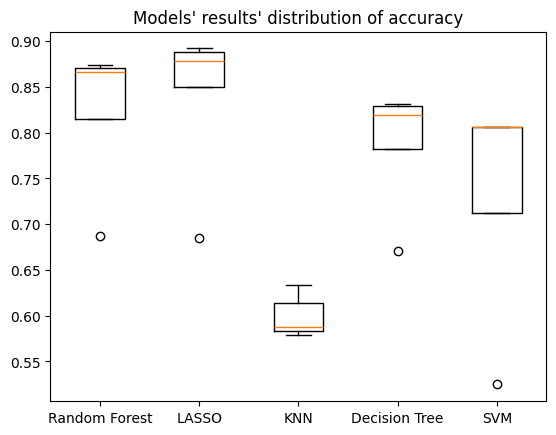

In [46]:
plt.boxplot(results, labels=names)
plt.title("Models' results' distribution of accuracy")
plt.show()

Logistic Regression with LASSO regulation is the best candidate.

In [47]:
model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)
print("The optimal hyperparameter 'C' is:", grid_search.best_params_["C"])


The optimal hyperparameter 'C' is: 3.158578947368421


In [48]:
model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=config_dict['seed'])
model.fit(x_features_train, y_labels_train)

LogisticRegression(C=np.float64(3.158578947368421), max_iter=1000,
                   random_state=0)

#Generate the ML train results: Use for Design Choices

In [49]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)

print("Results on the train set for a traditional ML model:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_train, 2))
print("Current model's accuracy:", round(accuracy_train, 2))
print("The accuracy lift is:", round(accuracy_lift_train), "%")

Results on the train set for a traditional ML model:
-------------------------
Baseline (dummy classifier) accuracy: 0.51
Current model's accuracy: 0.88
The accuracy lift is: 73 %


#Generate the ML test results: Use for presenting performance

In [50]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)

print("Results on the test set for a traditional ML model:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_test, 2))
print("Current model's accuracy:", round(accuracy_test, 2))
print("The accuracy lift is:", round(accuracy_lift), "%")


print("\nConfusion Matrix:")
print(confusion_matrix(y_labels_test, y_test_estimated))
print("\nClassification Report:")
print(classification_report(y_labels_test, y_test_estimated))

Results on the test set for a traditional ML model:
-------------------------
Baseline (dummy classifier) accuracy: 0.5
Current model's accuracy: 0.82
The accuracy lift is: 64 %

Confusion Matrix:
[[910  50]
 [288 664]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       960
           1       0.93      0.70      0.80       952

    accuracy                           0.82      1912
   macro avg       0.84      0.82      0.82      1912
weighted avg       0.84      0.82      0.82      1912



****
# Deep Learning  
Applying BERT, a Language Model to Text Classification

## Formatting our data
Adjusting the name of the label column:  
The design of the Transformers package requires the dataset's lables column to be named exactly `label`.  
In the above part of this notebook, where we did tranditional ML work, we had to pick a column name that **isn't** a natural word. The reason is that when we performed feature engineering, each word/Ngram was allocated its own column named after it. If the word "label" just happened to appear in the text, it could have a column called `label` defined for it in the dataframe, which would then **conflict with the labels' column name**.  
We no longer have that risk, and we need to comply with Transformers' requirements:  

Load the tokenizer and the pre-trained Language Model:  

*Note about fine tuning with Hugging Face:  
As of 2025, Hugging Face's Trainer defaults to log metrics using Weights & Biases. That means it demands an API key for that.  
To fine-tune without needing a W&B API key, you can disable this integration by setting an env variable `WANDB_DISABLED=true`.  

In [51]:
!export WANDB_DISABLED=true

In [52]:
labels = list(dataset_clean['is_depression'].unique())

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
language_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>
The previous cell would output a warnin starting with:  
`Some weights of the model checkpoint at bert-base-uncased were not used when initializing...`

>>
It is expected, as the model you imported had its pre-trained classification head (i.e. last neural layer) removed and a new "fresh" layer is initialized.  
That's what we want, as we seek to train that classification head to suit our dataset. Based on our choice, we may choose to also fine-tune other layers.    

In [53]:
print(f"The size of the model's token dictionary: {language_model.config.vocab_size}")

The size of the model's token dictionary: 30522


Split the dataset to three sub-sets:  
1. A held-out test set  
2. A train set that is split to two:  
  2.1 A subset used for training the neural network's parameters  
  2.2 A subset used to evaluate the progress of the training  

In [54]:
# Create a training set and a test set
test_df = dataset_clean.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
train_df = dataset_clean.drop(test_df.index)

# Splitting the train set to "just train" and "training evaluation" set:
train_eval_df = train_df.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
train_train_df = train_df.drop(train_eval_df.index)

# Rename the label column to 'label' as required by the Transformers Trainer
train_train_df = train_train_df.rename(columns={'is_depression': 'label'})
train_eval_df = train_eval_df.rename(columns={'is_depression': 'label'})
test_df = test_df.rename(columns={'is_depression': 'label'})

# Conver the dataframes to a Dataset format per the Transformers package's requirement:
dataset_train_train = Dataset.from_pandas(train_train_df)
dataset_train_eval = Dataset.from_pandas(train_eval_df)
dataset_test = Dataset.from_pandas(test_df)

In order for the LM to process the text, it must be tokenized:

In [55]:
def tokenize_function(examples):
    return tokenizer(examples['clean_text'], padding="max_length", truncation=True)

train_train_tokenized = dataset_train_train.map(tokenize_function, batched=True)
train_eval_tokenized = dataset_train_eval.map(tokenize_function, batched=True)
test_tokenized = dataset_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/4304 [00:00<?, ? examples/s]

Map:   0%|          | 0/1434 [00:00<?, ? examples/s]

Map:   0%|          | 0/1912 [00:00<?, ? examples/s]

#Training LM

We fine tune our pre-trained Language Model via transformers's Trainer.

### Choosing which neural network layers to fine-tune

In [56]:
if layers_to_fine_tune == "head":
  print("Fine-tuning only the classification head!")
  language_model.train()
  for name, param in language_model.named_parameters():
    # Freeze parameters of all layers except classifier head:
    if 'classifier' not in name:
        param.requires_grad = False
else:
  print("Fine-tuning the entire neural network!")

Fine-tuning the entire neural network!


### Training hyperparameters

These are the settings for training our model:

### Evaluation metric

Defining the evaluation metric for the Language Model fine-tuning:

In [57]:
metric = evaluate.load("accuracy")

Setting the metric evaluation function for the trainer to utilize:

In [58]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # As the model returns a pair of logit values for each observation,
    # where each of the two logit value reflects the likelihood of each
    # class, we want to conver it to a classification:
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Trainer object

In [59]:
trainer = Trainer(
    model=language_model,
    args=lm_training_args,
    train_dataset=train_train_tokenized,
    eval_dataset=train_eval_tokenized,
    compute_metrics=compute_metrics,
)

### Fine tuning

In [60]:
%%time
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.302900,0.541261,0.854951
200,0.202100,0.148270,0.965132
300,0.143000,0.154724,0.961646
400,0.126000,0.135026,0.971409
500,0.130800,0.142463,0.967225
600,0.113000,0.115292,0.972106
700,0.073500,0.264829,0.948396
800,0.070300,0.123237,0.972803
900,0.057600,0.141231,0.974198
1000,0.042200,0.169835,0.964435


CPU times: user 41min 5s, sys: 10.5 s, total: 41min 16s
Wall time: 44min 26s


TrainOutput(global_step=2152, training_loss=0.06862362338507853, metrics={'train_runtime': 2665.8115, 'train_samples_per_second': 6.458, 'train_steps_per_second': 0.807, 'total_flos': 4529719929077760.0, 'train_loss': 0.06862362338507853, 'epoch': 4.0})

Converting the training log to a dataframe for plotting:

In [61]:
training_logs_df = pd.DataFrame(trainer.state.log_history).groupby("step", as_index=False).first()

In [62]:
training_logs_df

,step,loss,grad_norm,learning_rate,epoch,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,100,0.3029,63.145550,1.907993e-05,0.185874,0.541261,0.854951,40.9310,35.035,4.398,NaN,NaN,NaN,NaN,NaN
1,200,0.2021,42.919769,1.815056e-05,0.371747,0.148270,0.965132,43.5601,32.920,4.132,NaN,NaN,NaN,NaN,NaN
2,300,0.1430,1.221200,1.722119e-05,0.557621,0.154724,0.961646,43.5305,32.942,4.135,NaN,NaN,NaN,NaN,NaN
3,400,0.1260,23.875391,1.629182e-05,0.743494,0.135026,0.971409,43.5372,32.937,4.134,NaN,NaN,NaN,NaN,NaN
4,500,0.1308,0.210633,1.536245e-05,0.929368,0.142463,0.967225,43.5301,32.943,4.135,NaN,NaN,NaN,NaN,NaN
5,600,0.1130,0.209041,1.443309e-05,1.115242,0.115292,0.972106,43.3812,33.056,4.149,NaN,NaN,NaN,NaN,NaN
6,700,0.0735,0.005241,1.350372e-05,1.301115,0.264829,0.948396,43.5424,32.933,4.134,NaN,NaN,NaN,NaN,NaN
7,800,0.0703,13.641635,1.257435e-05,1.486989,0.123237,0.972803,43.5253,32.946,4.136,NaN,NaN,NaN,NaN,NaN
8,900,0.0576,0.008095,1.164498e-05,1.672862,0.141231,0.974198,43.5233,32.948,4.136,NaN,NaN,NaN,NaN,NaN
9,1000,0.0422,0.111332,1.071561e-05,1.858736,0.169835,0.964435,43.5642,32.917,4.132,NaN,NaN,NaN,NaN,NaN


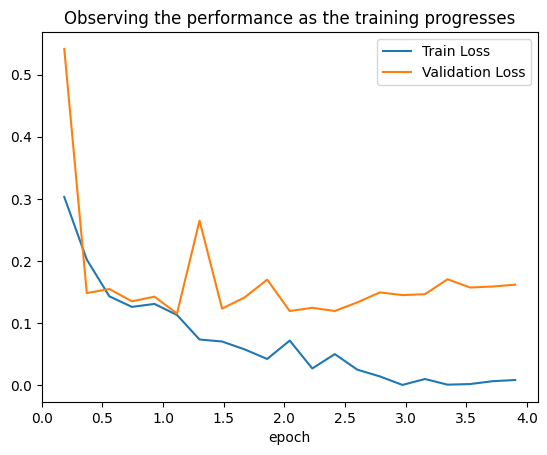

In [63]:
training_logs_df.plot(x="epoch", y=["loss", "eval_loss"])
plt.title('Observing the performance as the training progresses')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [64]:
results_train_train = trainer.predict(train_train_tokenized)#
predictions_train_train = np.argmax(results_train_train[0], axis=-1)

accuracy_dl_train = np.mean(predictions_train_train == train_train_df["label"])
baseline_accuracy_dl_train = np.mean(most_frequent_class == train_train_df["label"])
accuracy_dl_lift_train = 100 * (accuracy_dl_train/baseline_accuracy_dl_train - 1)

print("Results on the train set for a DL Language Model:\n----------------------------------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_dl_train, 2))
print("Current model's accuracy:", round(accuracy_dl_train, 2))
print("The accuracy lift is:", round(accuracy_dl_lift_train), "%")

Results on the train set for a DL Language Model:
----------------------------------------------------
Baseline (dummy classifier) accuracy: 0.51
Current model's accuracy: 1.0
The accuracy lift is: 95 %


What an improvement!

In [65]:
results_test = trainer.predict(test_tokenized)
predictions_test = np.argmax(results_test[0], axis=-1)

accuracy_dl_test = np.mean(predictions_test == test_df["label"])
baseline_accuracy_dl_test = np.mean(most_frequent_class == test_df["label"])
accuracy_dl_lift = 100 * (accuracy_dl_test/baseline_accuracy_dl_test - 1)

print("Results on the test set for a DL Language Model:\n---------------------------------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_dl_test, 2))
print("Current model's accuracy:", round(accuracy_dl_test, 2))
print("The accuracy lift is:", round(accuracy_dl_lift), "%")


print("\nConfusion Matrix:")
print(confusion_matrix(test_df["label"], predictions_test))
print("\nClassification Report:")
print(classification_report(test_df["label"], predictions_test))

Results on the test set for a DL Language Model:
---------------------------------------------------
Baseline (dummy classifier) accuracy: 0.5
Current model's accuracy: 0.97
The accuracy lift is: 93 %

Confusion Matrix:
[[945  15]
 [ 41 911]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       960
           1       0.98      0.96      0.97       952

    accuracy                           0.97      1912
   macro avg       0.97      0.97      0.97      1912
weighted avg       0.97      0.97      0.97      1912



The language model did a much better job than regular ML models. Now we can confidently make prediction for any messages and tell whether or not the speakers have depression symptom.

Reference: Mastering-NLP-from-Foundations-to-LLMs by Lior Gazit Meysam Ghaffari